<a href="https://colab.research.google.com/github/MekaRaptor/Graduation_Project/blob/main/model_DeeplabV3_renew.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [3]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import os

drive_path = "/content/drive/MyDrive/"  # ZIP dosyanın bulunduğu klasör
os.listdir(drive_path)  # Klasördeki dosyaları listele


['Classroom',
 'Alper_Ağırman_201180010 (1).txt',
 'Alper_Ağırman_201180010.txt',
 'Ceng307_201180010_HW1.sln',
 'Bilge Adam Data Science',
 'Untitled Diagram (4).drawio',
 'Untitled Diagram (3).drawio',
 'Document (1).sdr',
 'Untitled Diagram (2).drawio',
 'AI_Model - Made with Clipchamp_1718179352783.mp4',
 'Project Details',
 'Adsız sunu.gslides',
 'Untitled Diagram (1).drawio',
 'Neural_Network Documentation dokümanının çevrilmiş kopyası.gdoc',
 'Neural_Network Documentation.gdoc',
 'Literatür Taraması.gdoc',
 'Adsız doküman (2).gdoc',
 'Staj Raporu.gdoc',
 'Neural_Network Documentation (1).pdf',
 'staj2018-sablon (3).docx',
 'SRS_aciklamalar.gdoc',
 'SRS-Sablon.gdoc',
 'SDD_aciklamalar (1).gdoc',
 'SDD_aciklamalar.gdoc',
 'Untitled Diagram.drawio',
 'SPMP_Ornek.gdoc',
 'SDD-Sablon.gdoc',
 'week9.gdoc',
 'llm.gdoc',
 'clustering.gdoc',
 'cnn_rnn_gnn.gdoc',
 'NN.gdoc',
 'GAZI Midterm.gdoc',
 'Meet Recordings',
 'Bilgilendirme Metni (1).docx',
 'Bilgilendirme Metni.docx',
 'Do

In [5]:
import zipfile

zip_path = "/content/drive/MyDrive/Bitirme/Agriculture-Vision-2021.zip"  # ZIP dosyasının gerçek adını yaz
extract_path = "/content/veri_seti"  # Açılacağı yer

# ZIP dosyasını açma işlemi
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ ZIP dosyası başarıyla çıkarıldı.")


✅ ZIP dosyası başarıyla çıkarıldı.


In [6]:
dataset_path = "/content/veri_seti/Agriculture-Vision-2021"

# Ana klasörleri listeleyelim
folders = os.listdir(dataset_path)
print("📂 Veri Seti İçeriği:")
for folder in folders:
    print("-", folder)


📂 Veri Seti İçeriği:
- test
- train
- val


In [7]:
import os

# Ana klasör
dataset_path = "/content/veri_seti/Agriculture-Vision-2021"
train_path = os.path.join(dataset_path, "train")

# Alt klasör yolları
rgb_path = os.path.join(train_path, "images", "rgb")
nir_path = os.path.join(train_path, "images", "nir")
mask_path = os.path.join(train_path, "masks")  # ⬅️ Eksik olan burasıydı
label_path = os.path.join(train_path, "labels")

# Etiket sınıflarını klasör olarak alalım
label_classes = os.listdir(label_path)

print("📁 Etiket Sınıfları:")
for cls in label_classes:
    print("-", cls)


📁 Etiket Sınıfları:
- water
- waterway
- planter_skip
- storm_damage
- drydown
- nutrient_deficiency
- endrow
- double_plant
- weed_cluster


In [8]:
from PIL import Image
import os
import numpy as np

CLASS_NAMES = [
    "double_plant",
    "drydown",
    "endrow",
    "nutrient_deficiency",
    "planter_skip",
    "water",
    "waterway",
    "weed_cluster"
]
CLASS_NAME_TO_ID = {name: idx + 1 for idx, name in enumerate(CLASS_NAMES)}  # class 1–8


def combine_label_masks(label_root, output_path, image_size=(512, 512)):
    os.makedirs(output_path, exist_ok=True)
    ref_class = CLASS_NAMES[0]
    file_list = sorted(os.listdir(os.path.join(label_root, ref_class)))

    for filename in file_list:
        combined_mask = np.zeros(image_size, dtype=np.uint8)  # class 0 = background

        for class_name in CLASS_NAMES:
            class_id = CLASS_NAME_TO_ID[class_name]
            mask_path = os.path.join(label_root, class_name, filename)

            if os.path.exists(mask_path):
                mask = np.array(Image.open(mask_path).convert("L"))
                binary_mask = mask > 127
                combined_mask[binary_mask] = class_id

        Image.fromarray(combined_mask).save(os.path.join(output_path, filename))

    print(f"✅ {output_path} klasörüne {len(file_list)} etiket maskesi oluşturuldu.")


In [9]:
combine_label_masks(
    label_root="/content/veri_seti/Agriculture-Vision-2021/train/labels",
    output_path="/content/veri_seti/Agriculture-Vision-2021/train/combined_labels_clean"
)

combine_label_masks(
    label_root="/content/veri_seti/Agriculture-Vision-2021/val/labels",
    output_path="/content/veri_seti/Agriculture-Vision-2021/val/combined_labels_clean"
)


✅ /content/veri_seti/Agriculture-Vision-2021/train/combined_labels_clean klasörüne 56944 etiket maskesi oluşturuldu.
✅ /content/veri_seti/Agriculture-Vision-2021/val/combined_labels_clean klasörüne 18334 etiket maskesi oluşturuldu.


In [10]:
from torch.utils.data import Dataset
import torch
import numpy as np
import cv2

class AgricultureVisionDatasetV3(Dataset):
    def __init__(self, rgb_dir, nir_dir, label_dir, file_list, transform=None):
        self.rgb_dir = rgb_dir
        self.nir_dir = nir_dir
        self.label_dir = label_dir
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        base = self.file_list[idx]
        rgb = cv2.imread(os.path.join(self.rgb_dir, base + ".jpg"))
        nir = cv2.imread(os.path.join(self.nir_dir, base + ".jpg"), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(self.label_dir, base + ".png"), cv2.IMREAD_GRAYSCALE)

        nir = nir[..., np.newaxis]
        image = np.concatenate([rgb, nir], axis=2)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, torch.tensor(mask, dtype=torch.long)


In [11]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406, 0.5), std=(0.229, 0.225, 0.225, 0.5)),
    ToTensorV2()
])


In [12]:
# Geçerli dosya listesi
label_dir = "/content/veri_seti/Agriculture-Vision-2021/train/combined_labels_clean"
valid_filenames = [f.replace(".png", "") for f in os.listdir(label_dir) if f.endswith(".png")]

train_dataset = AgricultureVisionDatasetV3(
    rgb_dir="/content/veri_seti/Agriculture-Vision-2021/train/images/rgb",
    nir_dir="/content/veri_seti/Agriculture-Vision-2021/train/images/nir",
    label_dir=label_dir,
    file_list=valid_filenames,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)


In [13]:
model = deeplabv3_resnet50(weights=None)
model.classifier[4] = nn.Conv2d(256, 9, kernel_size=1)  # 0: background, 1–8: sınıflar
model.backbone.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
model = model.to("cuda")

weights = torch.tensor([0.5, 4.0, 2.0, 4.0, 3.0, 5.0, 2.0, 3.0, 4.0], device="cuda")  # 9 sınıf
criterion = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]


🎯 Class Weights: tensor([0.0009, 0.0814, 0.0052, 0.0757, 0.0087, 0.3398, 0.3453, 0.0644, 0.0682,
        0.0104], device='cuda:0')


In [14]:
epochs = 15
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to("cuda"), masks.to("cuda")
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"📘 Epoch {epoch+1}/{epochs} Loss: {avg_loss:.4f}")
    scheduler.step()


<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


📘 Epoch 1/15 Loss: 1.1681


<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


📘 Epoch 2/15 Loss: 0.8833


<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


📘 Epoch 3/15 Loss: 0.7781


<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


📘 Epoch 4/15 Loss: 0.7131


<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


📘 Epoch 5/15 Loss: 0.6759


<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


📘 Epoch 6/15 Loss: 0.5858


<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


📘 Epoch 7/15 Loss: 0.5592


<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


📘 Epoch 8/15 Loss: 0.5439


<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


📘 Epoch 9/15 Loss: 0.5297


<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


📘 Epoch 10/15 Loss: 0.5160


<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


📘 Epoch 11/15 Loss: 0.4786


<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


📘 Epoch 12/15 Loss: 0.4664


<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


📘 Epoch 13/15 Loss: 0.4578


<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


📘 Epoch 14/15 Loss: 0.4489


<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


📘 Epoch 15/15 Loss: 0.4442


In [15]:
# Modelin ağırlıklarını kaydet
local_path = "deeplabv3_rgbnir_finalv4.pth"
drive_path = "/content/drive/MyDrive/Bitirme/deeplabv3_rgbnir_finalv4.pth"

# Kaydet
torch.save(model.state_dict(), local_path)
torch.save(model.state_dict(), drive_path)

print("✅ Model başarıyla hem local'e hem de Google Drive'a kaydedildi.")


✅ Model başarıyla hem local'e hem de Google Drive'a kaydedildi.


In [16]:
val_label_dir = "/content/veri_seti/Agriculture-Vision-2021/val/combined_labels_clean"

val_files = [f.replace(".png", "") for f in os.listdir(val_label_dir) if f.endswith(".png")]



In [17]:
val_dataset = AgricultureVisionDatasetV3(
    rgb_dir="/content/veri_seti/Agriculture-Vision-2021/val/images/rgb",
    nir_dir="/content/veri_seti/Agriculture-Vision-2021/val/images/nir",
    label_dir=val_label_dir,
    file_list=val_files,
    transform=transform
)

val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)


In [18]:
from sklearn.metrics import confusion_matrix
import numpy as np

def calculate_miou(model, dataloader, num_classes=9):
    model.eval()
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to("cuda")
            masks = masks.to("cuda")
            outputs = model(images)['out']
            preds = torch.argmax(outputs, dim=1)

            true_np = masks.cpu().numpy().flatten()
            pred_np = preds.cpu().numpy().flatten()

            conf_matrix += confusion_matrix(
                true_np, pred_np, labels=list(range(num_classes))
            )

    iou_per_class = []
    for i in range(num_classes):
        TP = conf_matrix[i, i]
        FP = conf_matrix[:, i].sum() - TP
        FN = conf_matrix[i, :].sum() - TP
        denom = TP + FP + FN
        iou = TP / denom if denom != 0 else float('nan')
        iou_per_class.append(iou)

    miou = np.nanmean(iou_per_class)

    print("\n📊 Sınıf Bazlı IoU:")
    for i, iou in enumerate(iou_per_class):
        print(f"Class {i} IoU: {iou:.4f}")
    print(f"\n✅ Ortalama mIoU: {miou:.4f}")

    return iou_per_class, miou


In [19]:
iou_per_class, miou = calculate_miou(model, val_loader, num_classes=9)


<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)



📊 Sınıf Bazlı IoU:
Class 0 IoU: 0.6344
Class 1 IoU: 0.1917
Class 2 IoU: 0.5347
Class 3 IoU: 0.1916
Class 4 IoU: 0.3985
Class 5 IoU: 0.2042
Class 6 IoU: 0.4890
Class 7 IoU: 0.1948
Class 8 IoU: 0.2327

✅ Ortalama mIoU: 0.3413


<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-10-49bda8ed9bea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


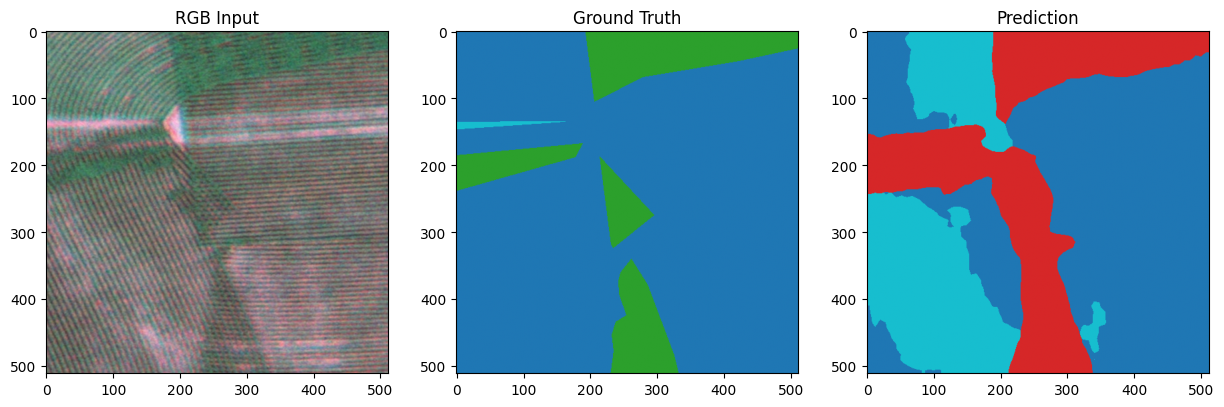

In [20]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for image, mask in val_loader:
        image = image.to("cuda")
        output = model(image)['out']

        # Get the prediction for the first image in the batch
        pred = torch.argmax(output[0], dim=0).cpu().numpy()

        # Get the mask for the first image in the batch
        mask = mask[0].cpu().numpy()

        original = image[0][:3].permute(1, 2, 0).cpu().numpy()
        original = (original * [0.229, 0.225, 0.225]) + [0.485, 0.456, 0.406]
        original = np.clip(original, 0, 1)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(original)
        plt.title("RGB Input")

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap="tab10") # Now mask has shape (512, 512)
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(pred, cmap="tab10") # Now pred has shape (512, 512)
        plt.title("Prediction")

        plt.show()
        break  # sadece 1 batch göster

In [15]:
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.nn as nn
import torch

# Modeli yeniden tanımla
model = deeplabv3_resnet50(weights=None)
model.classifier[4] = nn.Conv2d(256, 9, kernel_size=1)  # 9 sınıf
model.backbone.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)  # RGB + NIR = 4 kanal

# strict=False ile state_dict'i yükle
model.load_state_dict(torch.load("/content/drive/MyDrive/Bitirme/deeplabv3_rgbnir_best.pth"), strict=False)

model = model.to("cuda").eval()

In [17]:
from sklearn.model_selection import train_test_split

# Eğitimde kullandığın tüm dosyaların listesi valid_filenames değişkenindeydi
# Şimdi onun %20'sini validation için ayırıyoruz
train_files, val_files = train_test_split(valid_filenames, test_size=0.2, random_state=42)

# Validation dataset
val_dataset = AgricultureVisionDataset(
    rgb_dir="/content/veri_seti/Agriculture-Vision-2021/train/images/rgb",
    nir_dir="/content/veri_seti/Agriculture-Vision-2021/train/images/nir",
    label_dir="/content/veri_seti/Agriculture-Vision-2021/train/combined_labels",
    file_list=val_files,
    transform=transform  # aynı transform
)

val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

print("✅ Validation loader hazır.")


✅ Validation loader hazır.


<ipython-input-11-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)
<ipython-input-11-f8faf0936c5d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return image, torch.tensor(mask, dtype=torch.long)


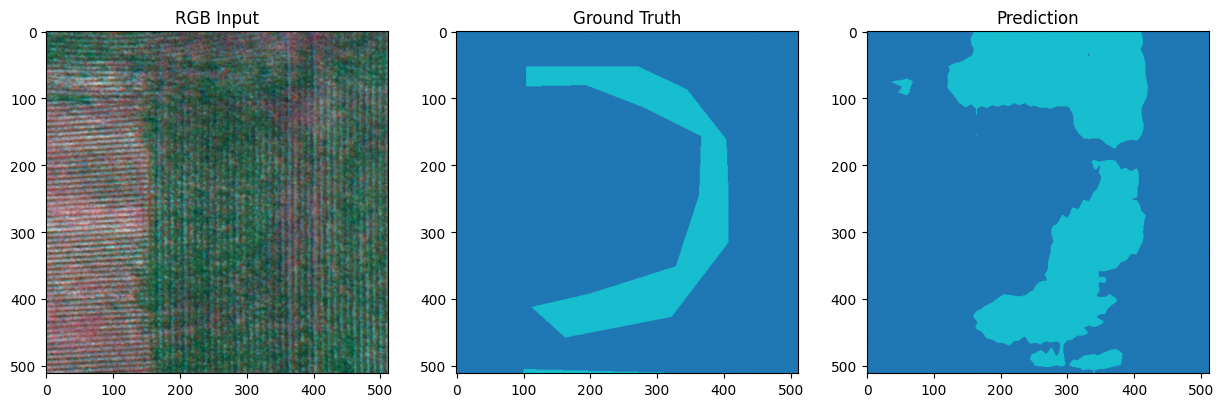

In [20]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    for image, mask in val_loader:
        image = image.to("cuda")
        output = model(image)['out']

        # Get the prediction for the first image in the batch
        pred = torch.argmax(output[0], dim=0).cpu().numpy()

        mask = mask[0].cpu().numpy()

        original = image[0][:3].permute(1, 2, 0).cpu().numpy()
        original = (original * [0.229, 0.225, 0.225]) + [0.485, 0.456, 0.406]
        original = np.clip(original, 0, 1)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(original)
        plt.title("RGB Input")

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap="tab10")
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(pred, cmap="tab10")
        plt.title("Prediction")

        plt.show()
        break  # Sadece ilk örneği göster

In [26]:
from collections import Counter
import numpy as np
import cv2
import os

# Bir örnek maske alalım
mask_path = "/content/veri_seti/Agriculture-Vision-2021/train/combined_labels/11IE4DKTR_11556-9586-12068-10098.png"

# Check if file exists
if os.path.exists(mask_path):
    sample_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if image was loaded successfully
    if sample_mask is not None:
        # Sınıf dağılımı
        print("Gerçek maske dağılımı:", Counter(sample_mask.flatten()))
    else:
        print(f"Error: Could not load image from {mask_path}")
else:
    print(f"Error: File not found at {mask_path}")

Gerçek maske dağılımı: Counter({np.uint8(0): 262144})


In [27]:
import os
import cv2
from collections import Counter

label_dir = "/content/veri_seti/Agriculture-Vision-2021/train/combined_labels"
total_counter = Counter()

files = [f for f in os.listdir(label_dir) if f.endswith(".png")]

for fname in files:
    path = os.path.join(label_dir, fname)
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if mask is not None:
        total_counter += Counter(mask.flatten())
    else:
        print(f"❗ Hatalı maske dosyası: {fname}")

print("\n✅ Toplam sınıf dağılımı:")
for cls, count in sorted(total_counter.items()):
    print(f"Sınıf {cls}: {count} piksel")



✅ Toplam sınıf dağılımı:
Sınıf 0: 10587656069 piksel
Sınıf 1: 1838496527 piksel
Sınıf 2: 126755024 piksel
Sınıf 3: 1107468572 piksel
Sınıf 4: 28225460 piksel
Sınıf 5: 27771992 piksel
Sınıf 6: 148987006 piksel
Sınıf 7: 140747558 piksel
Sınıf 8: 921419728 piksel


Text(0.5, 1.0, 'Modelin 0 (double_plant veya background) sınıfı tahmini')

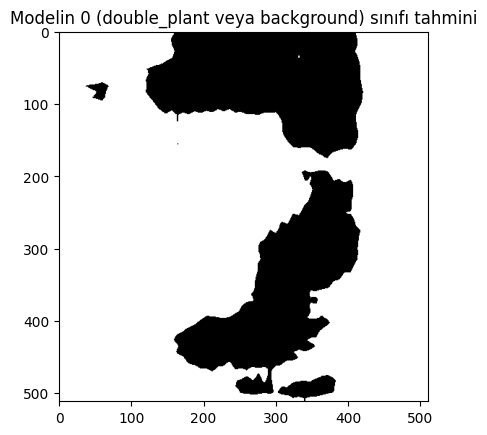

In [28]:
binary_mask = (pred == 0)
plt.imshow(binary_mask, cmap='gray')
plt.title("Modelin 0 (double_plant veya background) sınıfı tahmini")


In [29]:
overlap = (true_mask == 0) & (pred_mask == 0)
print("0 sınıfındaki gerçek-tahmin çakışan piksel sayısı:", np.sum(overlap))


NameError: name 'true_mask' is not defined

In [ ]:
unique_pred_classes = np.unique(pred_mask)
print("Modelin tahmin ettiği sınıflar:", unique_pred_classes)
